In [329]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate

import ipywidgets as widgets
from IPython.display import display
import pickle


import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial

import zuko
import lampe.inference
import lampe.utils
from tqdm.notebook import tqdm_notebook as tqdm
from lampe.utils import GDStep

from itertools import islice
from lampe.data import JointLoader

In [330]:
theta_true = torch.Tensor([0])
prior = torch.distributions.Normal(0, 5)
N=100
theta_grid = np.linspace(-15,15,1000)
N_simu = 50_000

In [331]:
zi = torch.distributions.Normal(theta_true, 1).sample((N,)).squeeze().tolist()
z1, z2 = zi[0], zi[1]

In [332]:

def posterior_z(thetas, z1=z1, z2=z2,sigma_y_2=1):
    """Posterior if we observe z1, z2"""
    def improper_posterior_z(theta, z1=z1, z2=z2):
        likelihood_part = -(np.square(theta-z1) + np.square(theta-z2))/(2*sigma_y_2**2)
        prior_part = np.square(theta)/50
        res = np.exp(likelihood_part)*np.exp(prior_part)
        return res
    Z_z1_z2, eps = integrate.quad(improper_posterior_z,-15,15) #Integral of p_impropre(θ|z1,z2)
    return [improper_posterior_z(theta,z1,z2)/Z_z1_z2 for theta in thetas]
x = (z1 + z2)/2
def posterior_x(thetas, x=x, sigma_2_y=1):
    """Posterior when observing x=mean(z1, z2)"""
    def improper_posterior_x(theta, x=x):
        likelihood_part = -np.square(theta - x)/sigma_2_y**2
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_x, eps = integrate.quad(improper_posterior_x, -15, 15)
    return [improper_posterior_x(theta,x)/z_x for theta in thetas]
x = np.mean(zi)
def posterior_x_N(thetas, x=x,sigma_2_y=1):
    """Posterior when observing x= mean(z1, z2... ,zn)"""
    def improper_posterior_x_N(theta, x=x):
        likelihood_part = -N*np.square(theta -x)/(2*sigma_2_y**2)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_x_n, eps = integrate.quad(improper_posterior_x_N,-15, 15)
    
    return [improper_posterior_x_N(theta,x)/z_x_n for theta in thetas]
x1 = np.mean(zi)
x2 = np.var(zi)
def posterior_summaries(thetas, x1=x1, x2=x2,sigma_2_y=1):

    """Posterior when observing x= mean(z1...zn), var(z1...zn)"""
    def improper_posterior_summaries(theta,x1=x1,x2=x2):
        likelihood_x1_part = -N*np.square(theta - x1)/(2*sigma_2_y**2)
        likelihood_x2_part = -N*np.square(sigma_2_y**2 - x2)/(2*sigma_2_y*sigma_2_y)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_x1_part)*np.exp(likelihood_x2_part)*np.exp(prior_part)
    z_summaries, eps = integrate.quad(improper_posterior_summaries, -25, 25)
    return [improper_posterior_summaries(theta,x1,x2)/z_summaries for theta in thetas]

#x=np.var(zi)
def posterior_var(thetas, x=x):
    """Posterior when observing x= var(z1...zn)"""
    def improper_posterior_var(theta,x=x):
        likelihood_part = -N*np.square(x-1)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_summaries, eps = integrate.quad(improper_posterior_var, -25, 25)
    return [improper_posterior_var(theta,x)/z_summaries for theta in thetas]


In [333]:
def get_true_post(summaries, x_star,sigma_y_2=1):
    theta_grid_t = torch.tensor(theta_grid)  # Convert theta_grid to a torch tensor

    if "two_z" == summaries:
        # We observe z1, z2
        post = posterior_z(theta_grid_t, x_star[0], x_star[1],sigma_y_2) 
        dist = posterior_z
    elif "mean_two_z" == summaries:
        # We observed x = mean(z1, z2)
        post = posterior_x(theta_grid_t, x_star,sigma_y_2) 
        dist = posterior_x
    elif "var" == summaries:
        # We observe x = var(z1...zn)
        post = posterior_var(theta_grid_t, x_star,sigma_y_2) 
        dist = posterior_var
    elif "var" in summaries and "mean" in summaries:
        # We observe x = (x1, x2) = (mean, var)
        post = posterior_summaries(theta_grid_t, x_star[0], x_star[1],sigma_y_2) 
        dist = posterior_summaries
    elif "mean" == summaries:
        # We observe x = mean(z1, ... z100)
        post = posterior_x_N(theta_grid_t, x_star,sigma_y_2)
        dist = posterior_x_N

    post = torch.stack(post).cuda()  # Move post to CUDA
    return post


In [334]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [335]:
def generate_data(thetas, sigma_y_2=1):
    N = thetas.shape[0]
    res = {}
    means = torch.zeros((N, 1), device=device)
    means_two_z = torch.zeros((N, 1), device=device)
    means_and_vars = torch.zeros((N, 2), device=device)
    vars = torch.zeros((N, 1), device=device)
    raws = torch.zeros((N, 1), device=device)
    two_z_l = torch.zeros((N, 2), device=device)
    
    with tqdm(thetas, unit='theta', leave=False, desc="Generating data") as tq:
        for i, theta in enumerate(tq):
            z = torch.distributions.Normal(theta, 1).sample((100,)).to(device)
            mean = z.mean()
            var = z.var()
            z0, z1 = z[0], z[1]
            mean_two_z = torch.mean(torch.stack([z0, z1]))
            
            means[i] = mean
            means_two_z[i] = mean_two_z.unsqueeze_(0)
            means_and_vars[i] = torch.stack([mean.unsqueeze_(0), var.unsqueeze_(0)]).squeeze_()
            two_z_l[i] = torch.stack([z0, z1]).squeeze_()
            vars[i] = var
            raws[i] = z0
            
    res["mean"] = {"x": means}
    res["mean_two_z"] = {"x": means_two_z}
    res["mean_and_var"] = {"x": means_and_vars}
    res["two_z"] = {"x": two_z_l}
    res["raw_z"] = {"x": raws}
    res["var"] = {"x": vars}
    
    for key in res.keys():
        epsilons = torch.distributions.Normal(torch.zeros_like(res[key]["x"]), np.sqrt(sigma_y_2)).sample().to(device)
        res[key]["eps"] = epsilons
        scale_mean, scale_std = res[key]["x"].mean(0), res[key]["x"].std(0)
        res[key]["scale_parameters"] = scale_mean, scale_std
        res[key]["scaled_x"] = (res[key]["x"] - scale_mean) / scale_std
        
    return res


In [336]:
summary = "mean_and_var"
sigma_2_y = 1

In [337]:
def scale(quantity):
    mean = quantity.mean(0)
    std = quantity.std(0)
    return (quantity-mean)/std, mean, std


In [338]:
def build_nsf(features, context):
    """Callable to instantiate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5).to(device)

def train_flow(flow, loss, theta, x, theta_test, x_test):
    optimizer = torch.optim.Adam(flow.parameters(), lr=5e-3)
    theta_test = theta_test.unsqueeze(-1).to(device)
    data = lampe.data.JointDataset(theta.to(device), x.to(device))
    loader = lampe.data.DataLoader(data, 256)
    
    with torch.no_grad():
        min_loss = loss(theta_test, x_test.to(device))
    min_loss_list = [min_loss.item()]  # Convert min_loss to a scalar
    
    flow.train()

    with tqdm(range(50), unit='epoch', leave=False, desc="Training NPE") as tq:
        for epoch in tq:
            for theta_batch, x_batch in loader:
                theta_batch = theta_batch.unsqueeze(-1).to(device)
                x_batch = x_batch.to(device)
                losses = loss(theta_batch, x_batch)
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
            
            # Checking for early stopping
            with torch.no_grad():
                loss_test = loss(theta_test, x_test.to(device))
                min_loss_list.append(loss_test.item())  # Convert loss_test to a scalar
                if len(min_loss_list) - np.argmin(min_loss_list) > 5: # No improvement in loss(test) for the last 5 iterations
                    # Early stop  
                    tq.close()
                    break
            tq.set_postfix(loss=loss_test.item())
    flow.eval()
    return flow

def create_train_flow(summaries, theta, data, theta_test, data_test):
    shape_x = lambda x: 2 if x == "mean_and_var" or x == "two_z" else 1
    flow = lampe.inference.NPE(theta_dim=1, x_dim=shape_x(summaries), build=build_nsf).to(device)
    loss = lampe.inference.NPELoss(flow).to(device)
    x = data[summaries]["scaled_x"].to(device)
    x_test = data_test[summaries]["scaled_x"].to(device)
    flow = train_flow(flow, loss, theta, x, theta_test, x_test)
    return flow


theta = prior.sample((N_simu, )).to(device)
theta_test = prior.sample((N_simu // 10, )).to(device)
theta_scaled, theta_means, theta_stds = scale(theta)
theta_test_scaled, _, __ = scale(theta_test)
data = generate_data(theta, sigma_2_y)
data_test = generate_data(theta_test, sigma_2_y)
q_NPE = create_train_flow(summary, theta, data, theta_test, data_test) #!


Generating data:   0%|          | 0/50000 [00:00<?, ?theta/s]

Generating data:   0%|          | 0/5000 [00:00<?, ?theta/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

In [339]:
true_obs_data = generate_data(theta_true, sigma_2_y)
x0 = true_obs_data[summary]["x"].to(device)
y0 = x0 + true_obs_data[summary]["eps"].to(device)

x0_scaled = (x0 - data[summary]["scale_parameters"][0])/data[summary]["scale_parameters"][1]
y0_scaled = (y0 - data[summary]["scale_parameters"][0]/data[summary]["scale_parameters"][1])

Generating data:   0%|          | 0/1 [00:00<?, ?theta/s]

In [344]:
def train_unconditional_flow(flow, loss, x, x_test):
    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
    loader = torch.utils.data.DataLoader(x.to(device), 256)
    
    with torch.no_grad():
        min_loss = loss(x_test.to(device))
    min_loss_list = [min_loss.item()]  # Convert min_loss to a scalar
    
    flow.train()

    with tqdm(range(50), unit='epoch', leave=False, desc="Training NPE") as tq:
        for epoch in tq:
            for x_batch in loader:
                x_batch = x_batch.to(device)
                losses = loss(x_batch)
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
            
            # Checking for early stopping
            with torch.no_grad():
                loss_test = loss(x_test.to(device))
                min_loss_list.append(loss_test.item())  # Convert loss_test to a scalar
                if len(min_loss_list) - np.argmin(min_loss_list) > 5: # No improvement in loss(test) for the last 5 iterations
                    # Early stop  
                    tq.close()
                    break
            tq.set_postfix(loss=loss_test.item())
    flow.eval()
    return flow

def create_train_unconditional_flow(summaries, data, data_test):
    shape_x = lambda x: 2 if x == "mean_and_var" or x == "two_z" else 1
    flow = zuko.flows.NAF(features=shape_x(summaries), context=0).to(device)
    loss = lambda x: -flow().log_prob(x).mean()
    x = data[summaries]["scaled_x"].to(device)
    x_test = data_test[summaries]["scaled_x"].to(device)
    flow = train_unconditional_flow(flow, loss, x, x_test)
    return flow



q_x_NF = create_train_unconditional_flow(summary, data, data_test)


In [ ]:
TODO Essayer sans stdiser même avec q_x ?? 

In [340]:
npe_samples_x = q_NPE.sample(x0_scaled,(20_000,))
npe_samples_rescaled_x = (npe_samples_x+theta_means)*theta_stds
true_post = get_true_post(summary,x0.squeeze().cpu().numpy())

npe_samples_y = q_NPE.sample(y0_scaled,(20_000,))
npe_samples_rescaled_y =(npe_samples_y+theta_means)*theta_stds
theoritical_post_y = get_true_post(summary,y0.squeeze().cpu().numpy(),sigma_2_y)

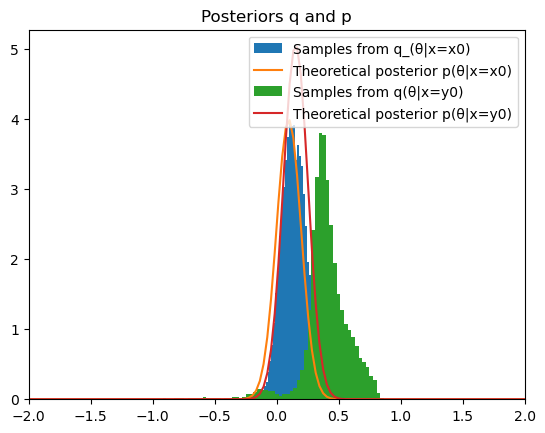

In [341]:
fig, ax = plt.subplots()
ax.hist(npe_samples_x.squeeze().cpu(), bins=400, density=True, label="Samples from q_(θ|x=x0)") #!
ax.plot(theta_grid, true_post.cpu(), label="Theoretical posterior p(θ|x=x0)")
ax.hist(npe_samples_y.squeeze().cpu(), bins=200, density=True, label="Samples from q(θ|x=y0)") #!
ax.plot(theta_grid, theoritical_post_y.cpu(), label="Theoretical posterior p(θ|x=y0)")

ax.set_title("Posteriors q and p")
ax.set_xlim(-2, 2)
ax.legend()
plt.show()

In [345]:
M = 100_000
warm_up_steps = 20_000

sigma = 0.01
tau = 0.25
rho = 1/2

In [346]:
import torch
import torch.distributions as dist
from tqdm import tqdm



# Define the proposal function
def proposal(x_curr):
    return x_curr + dist.Normal(0, 1).sample(x_curr.shape).to(device)

# Define the f function
def f(y0, x, rho, sigma, tau, q_x_NF):
    D = 2
    res = torch.zeros_like(y0)

    for j in range(D):
        xj = x[j]
        yj = y0[j]
        zj = dist.Bernoulli(rho).sample().to(device)
        if not zj:
            spike_dist = dist.Normal(xj.detach(), torch.tensor(sigma).to(device))
            res[j] = torch.exp(spike_dist.log_prob(yj))
        else:
            slab_dist = dist.Cauchy(xj.detach(), torch.tensor(tau).to(device))
            res[j] = torch.exp(slab_dist.log_prob(yj))
    return res * torch.exp(q_x_NF().log_prob(x))

def mcmc(x0, warm_up_steps, M, y0, rho, sigma, tau, q_x_NF):
    x_curr = x0.to(device)
    my_samples = torch.empty((warm_up_steps + M, x0.shape[0])).to(device)
    log_f_x_curr = f(y0, x_curr, rho, sigma, tau, q_x_NF).log()
    
    with tqdm(total=warm_up_steps + M, unit='iteration', leave=False, desc="Sampling xm using MH algorithm") as pbar:
        for i in range(warm_up_steps + M):
            x_star = proposal(x_curr)
            log_f_x_star = f(y0, x_star, rho, sigma, tau, q_x_NF).log()

            log_a = log_f_x_star - log_f_x_curr

            a = torch.exp(log_a)

            u = torch.cuda.FloatTensor(a.shape).uniform_().to(device)

            mask = u < a

            x_curr = torch.where(mask, x_star, x_curr)
            log_f_x_curr = torch.where(mask, log_f_x_star, log_f_x_curr)

            my_samples[i] = x_curr
            pbar.update(1)

    my_samples = my_samples[warm_up_steps:]
    return my_samples

with torch.no_grad():
    xm = mcmc(torch.zeros_like(data[summary]["x"][0]).to(device), warm_up_steps, M, y0_scaled.squeeze().to(device), rho, sigma, tau, q_x_NF)


Sampling xm using MH algorithm:   0%|          | 0/120000 [00:00<?, ?iteration/s]

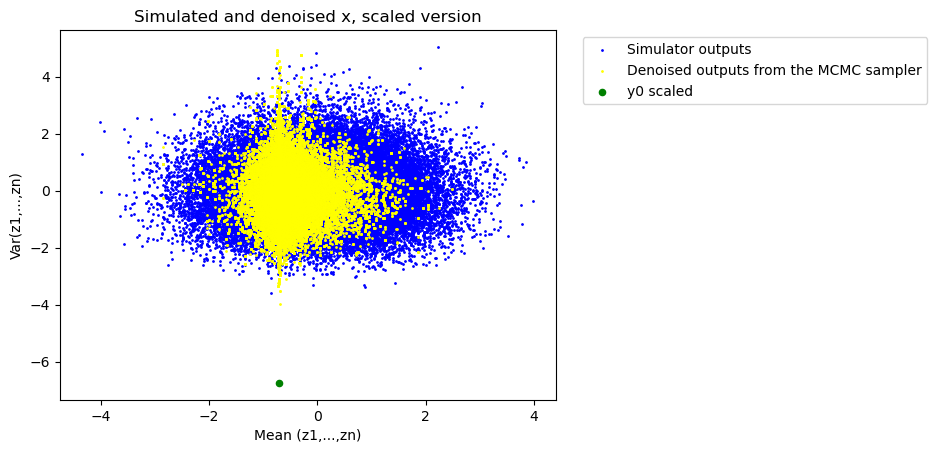

In [319]:
fig, ax = plt.subplots()

ax.scatter(x=data[summary]["scaled_x"][:,0].cpu(),y=data[summary]["scaled_x"][:,1].cpu(), color="blue", label="Simulator outputs", s=1)
ax.scatter(x=xm[:,0].cpu(),y=xm[:,1].cpu(), label="Denoised outputs from the MCMC sampler", color="yellow", s=1)
ax.scatter(x=y0_scaled.cpu()[:,0],y=y0_scaled.cpu()[:,1], label="y0 scaled", color="green", s=20)
ax.set_xlabel("Mean (z1,...,zn)")
ax.set_ylabel("Var(z1,...,zn)")
ax.set_title("Simulated and denoised x, scaled version")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [320]:
rnpe_samples = q_NPE.sample((xm+data[summary]["scale_parameters"][0])*data[summary]["scale_parameters"][1])
rnpe_samples_unscaled = (rnpe_samples+theta_means)*theta_stds

In [321]:
true_post_y = posterior_summaries(theta_grid, y0.cpu().squeeze()[0].item(),y0.cpu().squeeze()[1].item(),sigma_2_y)

In [322]:
npe_samples = q_NPE.sample(y0_scaled)

In [323]:
rnpe_samples

tensor([[-3.5919],
        [-3.5947],
        [-3.5592],
        ...,
        [-3.5104],
        [-3.5122],
        [-3.5233]])

In [324]:
rnpe_samples

tensor([[-3.5919],
        [-3.5947],
        [-3.5592],
        ...,
        [-3.5104],
        [-3.5122],
        [-3.5233]])

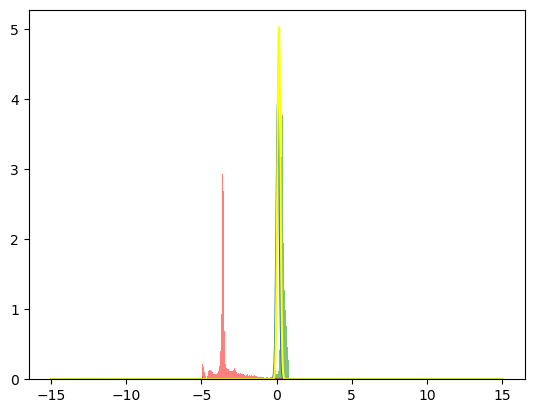

In [349]:
plt.hist(npe_samples_y.squeeze().cpu(),bins=200, density=True,color="green",alpha=0.5)
plt.hist(rnpe_samples.squeeze().cpu(),bins=200, density=True, color="red",alpha=0.5)
plt.plot(theta_grid,true_post.cpu())
plt.plot(theta_grid,theoritical_post_y.cpu(),color='yellow')
#plt.xlim(-2,2)